In [1]:
import matplotlib.pyplot as plt
import numpy as np

from collections import deque
from math import inf, sqrt, fabs

In [2]:
WALL = -1
OPEN = 1


def get_grid_graph(add_costs=False, add_rough_patch=False, add_walls=True):
    size = 16
    psize = 4

    if add_costs:
        grid = np.random.randint(low=OPEN + 1, high=10, size=(size, size), dtype=np.int)
    else:
        grid = np.ones((size, size), dtype=np.int) * OPEN

    if add_rough_patch:
        patch = np.random.randint(low=50, high=75, size=(psize, psize))
        grid[9 : 9 + psize, :psize] = patch

    if add_walls:
        grid[2, 2:-2] = WALL  # Lower horizontal wall
        grid[-3, 2:-2] = WALL  # Upper horizontal wall
        grid[3:-3, -3] = WALL  # Vertical wall
        grid[5:-5, 8] = WALL  # Isolated vertical wall

    return grid


def get_vertex_neighbors(graph, vertex):

    height, width = graph.shape
    col, row = vertex

    def inbounds(v):
        c, r = v
        return 0 <= c < width and 0 <= r < height

    def not_wall(v):
        c, r = v
        return graph[r, c] != WALL

    possible_neighbors = [
        (col + 1, row),
        (col - 1, row),
        (col, row + 1),
        (col, row - 1),
    ]

    return [nei for nei in possible_neighbors if inbounds(nei) and not_wall(nei)]


def show_grid_graph(
    graph, start, end, path=None, visited=None, costs=False, title=None, ax=None
):

    if ax == None:
        _, ax = plt.subplots(1, 1, figsize=(8, 8))

    YELLOW = (255, 255, 0)
    LIGHT_GRAY = (200, 200, 200)
    BLUE = (0, 0, 255)
    RED = (255, 0, 0)
    GREEN = (0, 255, 0)
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)

    # Expand graph to three channels to plot as an image
    graph_img = np.repeat(graph[:, :, np.newaxis], 3, axis=2)
    graph_img[graph == OPEN] = WHITE

    # Add walls
    graph_img[graph == WALL] = BLACK

    if visited and costs:
        graph_img[graph != WALL] = 255 - graph_img[graph != WALL]
        for (j, i), label in np.ndenumerate(graph):
            text_color = "pink" if (i, j) in visited else "black"
            ax.text(i, j, label, color=text_color, ha="center", va="center")

    elif visited and not costs:
        cols, rows = zip(*visited)
        graph_img[rows, cols] = LIGHT_GRAY

    elif not visited and costs:
        graph_img[graph != WALL] = 255 - graph_img[graph != WALL]
        for (j, i), label in np.ndenumerate(graph):
            ax.text(i, j, label, ha="center", va="center")

    # Add path
    if path != None:
        cols, rows = zip(*path)
        graph_img[rows, cols] = YELLOW

    # Add start and end locations
    graph_img[start[1], start[0]] = BLUE
    graph_img[end[1], end[0]] = RED

    ax.imshow(np.clip(graph_img, 0, 255) / 255, origin="lower", aspect="equal")

    if title != None:
        ax.set_title(title)

    # Ticks
    size = graph_img.shape[0]
    ax.set_xticks(np.arange(0, size, 1))
    ax.set_yticks(np.arange(0, size, 1))
    ax.set_xticks(np.arange(-0.5, size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, size, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which="minor", color="gray", linestyle="-", linewidth=1)

    return ax

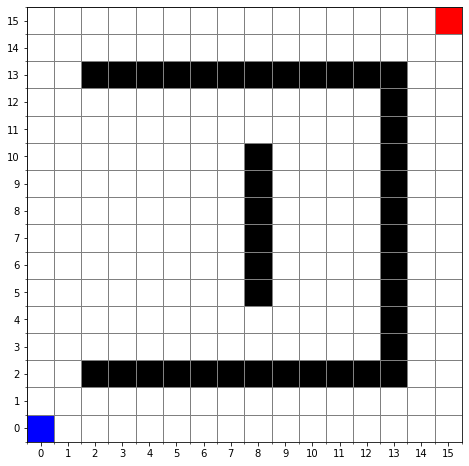

In [3]:
graph = get_grid_graph()
show_grid_graph(graph, (0, 0), (15, 15));

In [4]:
def get_path_from_preds(preds, end):
    current = end
    path = [current]
    while preds[current] != None:
        current = preds[current]
        path.append(current)

    path.reverse()
    return path

In [5]:
def get_path_bfs(graph, start, end):
    vertices_to_visit = deque()
    vertices_to_visit.append(start)

    predecessors = {start: None}

    while len(vertices_to_visit) > 0:

        from_vertex = vertices_to_visit.popleft()

        for to_vertex in get_vertex_neighbors(graph, from_vertex):

            if to_vertex not in predecessors:

                vertices_to_visit.append(to_vertex)
                predecessors[to_vertex] = from_vertex

                if to_vertex == end:
                    path = get_path_from_preds(predecessors, end)
                    return path, list(predecessors.keys())

    return None, None

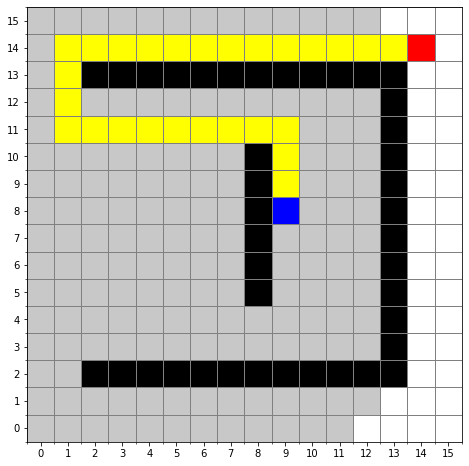

In [6]:
start = (9, 8)
end = (14, 14)

graph = get_grid_graph()

path, visited = get_path_bfs(graph, start, end)

show_grid_graph(graph, start, end, path, visited);

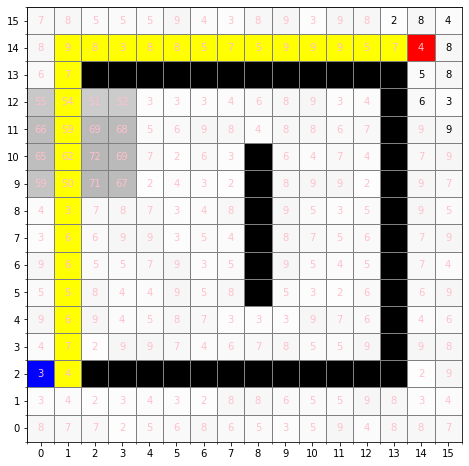

In [7]:
start = (0, 2)
end = (14, 14)

graph_weighted = get_grid_graph(add_costs=True, add_rough_patch=True)

path, visited = get_path_bfs(graph_weighted, start, end)

show_grid_graph(graph_weighted, start, end, path, visited, True);

In [8]:
def get_path_slow_dijkstras(graph, start, end):
    visited = {start}
    predecessors = {start: None}
    path_lengths = {start: 0}
    
    while True:
        
        length_of_min_path = inf
        to_vertex_of_min_path = None
        from_vertex_of_min_path = None
        
        for from_vertex in visited:
            
            for to_vertex in get_vertex_neighbors(graph, from_vertex):
                
                if to_vertex not in visited:
                    
                    col, row = to_vertex
                    to_weight = graph[row, col]
                    
                    to_path_length = path_lengths[from_vertex] + to_weight
                    
                    if to_path_length < length_of_min_path:
                        
                        length_of_min_path = to_path_length
                        to_vertex_of_min_path = to_vertex
                        from_vertex_of_min_path = from_vertex
        
        path_lengths[to_vertex_of_min_path] = length_of_min_path
        predecessors[to_vertex_of_min_path] = from_vertex_of_min_path
        visited.add(to_vertex_of_min_path)

        if to_vertex_of_min_path == end:
            path = get_path_from_preds(predecessors, end)
            return path, list(predecessors.keys())

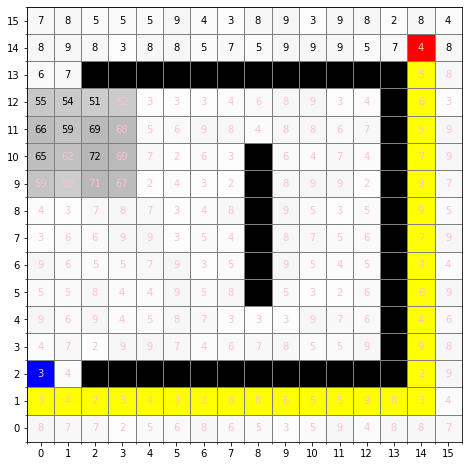

In [9]:
start = (0, 2)
end = (14, 14)

# Use same graph as above unless this is uncommented
# graph_weighted = get_grid_graph(add_costs=True, add_rough_patch=True)

path, visited = get_path_slow_dijkstras(graph_weighted, start, end)

show_grid_graph(graph_weighted, start, end, path, visited, True);

In [10]:
def heuristic_cost(v1, v2):
#     return sqrt((v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2)
    return 3.5 * (fabs(v1[0] - v2[0]) + fabs(v1[1] - v2[1]))


def get_path_slow_astar(graph, start, end):
    vertices_to_visit = {start}
    predecessors = {start: None}

    # Path lengths from start to each vertex
    height, width = graph.shape
    path_lengths_from_start = {
        (col, row): inf for col in range(width) for row in range(height)
    }
    path_lengths_from_start[start] = 0

    # Possible path lengths from start to end through given vertex
    guessed_path_lengths_to_end = {start: heuristic_cost(start, end)}
    
    visited = set()

    while len(vertices_to_visit) > 0:

        length_of_min_guessed_path = inf

        for from_vertex in vertices_to_visit:

            length_of_guessed_path = guessed_path_lengths_to_end[from_vertex]
            
            if length_of_guessed_path < length_of_min_guessed_path:

                length_of_min_guessed_path = length_of_guessed_path
                from_vertex_of_min_guessed_path = from_vertex

        vertices_to_visit.remove(from_vertex_of_min_guessed_path)
        visited.add(from_vertex_of_min_guessed_path)

        from_vertex_path_length = path_lengths_from_start[
            from_vertex_of_min_guessed_path
        ]

        for to_vertex in get_vertex_neighbors(graph, from_vertex_of_min_guessed_path):

            col, row = to_vertex
            updated_length = from_vertex_path_length + graph[row, col]

            if updated_length < path_lengths_from_start[to_vertex]:

                predecessors[to_vertex] = from_vertex_of_min_guessed_path
                path_lengths_from_start[to_vertex] = updated_length
                guessed_path_lengths_to_end[
                    to_vertex
                ] = updated_length + heuristic_cost(to_vertex, end)

                if to_vertex == end:
                    path = get_path_from_preds(predecessors, end)
                    return path, list(visited)

                if to_vertex not in vertices_to_visit:
                    vertices_to_visit.add(to_vertex)

    return None, None

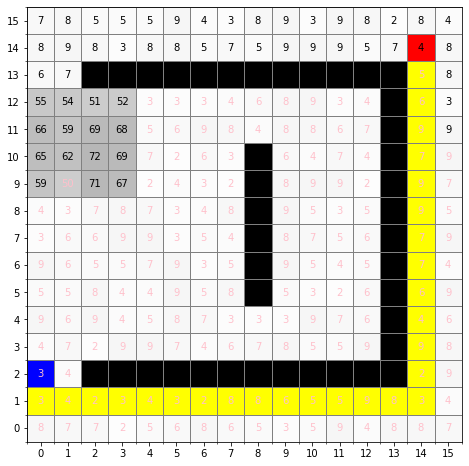

In [11]:
start = (0, 2)
end = (14, 14)

# Use same graph as above unless this is uncommented
# graph_weighted = get_grid_graph(add_costs=True, add_rough_patch=True)

path, visited = get_path_slow_astar(graph_weighted, start, end)

show_grid_graph(graph_weighted, start, end, path, visited, True);

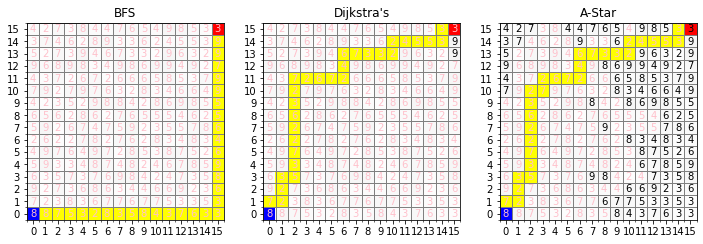

In [12]:
start = (0, 0)
end = (15, 15)

costs = True

graph_weighted = get_grid_graph(add_walls=False, add_costs=costs)

path_bfs, visit_bfs = get_path_bfs(graph_weighted, start, end)
path_dij, visit_dij = get_path_slow_dijkstras(graph_weighted, start, end)
path_ast, visit_ast = get_path_slow_astar(graph_weighted, start, end)

_, axes = plt.subplots(1, 3, figsize=(12, 5))

show_grid_graph(graph_weighted, start, end, path_bfs, visit_bfs, costs, "BFS", ax=axes[0]);
show_grid_graph(graph_weighted, start, end, path_dij, visit_dij, costs, "Dijkstra's", ax=axes[1]);
show_grid_graph(graph_weighted, start, end, path_ast, visit_ast, costs, "A-Star", ax=axes[2]);